# Proyecto de Robótica - Verano 2023
## Integrante responsable de este algoritmo: Luis Ramón Guajardo

*   Miguel Ángel Paz
*   Luis Ramón Guajardo
*   Jafet Castañeda
*   Andrés Suro



# Generación del Laberinto

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import numpy as np
from matplotlib import collections  as mc
import random
import pandas as pd

import tensorflow as tf
import keras as keras
from keras.layers import PReLU
from keras import layers, losses, models
from keras.models import Model

from sklearn.neural_network import MLPRegressor 

import time

In [2]:
class Obstacle:
  pos = ''
  width = ''
  height = ''

  def __init__(self, p, w, h):
    self.pos = p
    self.width = w
    self.height = h


## Laberinto 1

In [3]:
obstacles = []
obstacles.append(Obstacle((1,1), 2, 5))
obstacles.append(Obstacle((6, 6), 2, 2))
obstacles.append(Obstacle((5, 2), 3, 1))
obstacles.append(Obstacle((4, 4), 0.5, 5))

In [4]:
obstacles = []
obstacles.append(Obstacle((3,5), 4, 6.5))
obstacles.append(Obstacle((2.5, 0), 6, 4.3))

In [5]:
liminf_X = 0
limsup_X = 10
liminf_Y = 0
limsup_Y = 10

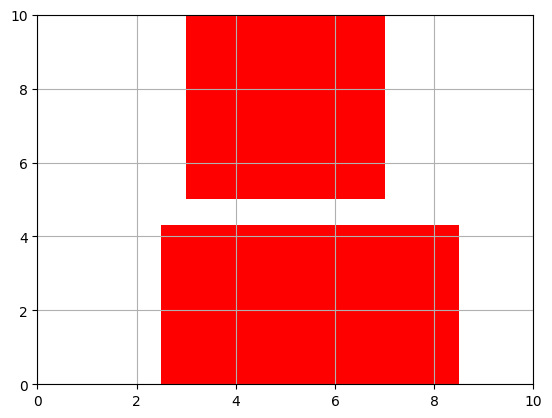

In [6]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))
plt.grid()
plt.show()

## Laberinto 2 (Para pruebas)

In [7]:
liminf_X = 0
limsup_X = 8
liminf_Y = 0
limsup_Y = 8

In [8]:
obstacles = []
wt = 0.25/2

#Paredes del laberinto
obstacles.append(Obstacle((2-wt,0), 0.25, 2 + wt))
obstacles.append(Obstacle((2+wt, 2-wt), 2, 0.25))

obstacles.append(Obstacle((0, 4-wt), 4-wt, 0.25))
obstacles.append(Obstacle((4-wt, 4-wt), 0.25, 2 + 2*wt))
obstacles.append(Obstacle((2-wt, 6-wt), 2, 0.25))

obstacles.append(Obstacle((6-wt, 6-wt), 0.25, 2 + 2*wt))

obstacles.append(Obstacle((6-wt, 2-wt), 0.25, 2 + 2*wt))
obstacles.append(Obstacle((6+wt, 4-wt), 2-wt, 0.25))

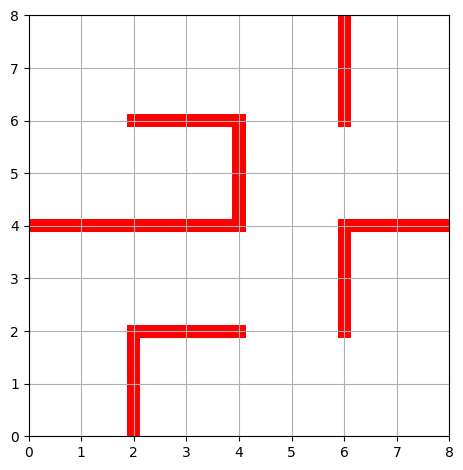

In [9]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

plt.grid()
plt.tight_layout()
plt.show()

# Primitive Functions

## Colisiones de puntos

In [10]:
# CIRCLE/RECTANGLE
def circleRect(cx,cy,radius, rx, ry, rw, rh):

  # temporary variables to set edges for testing
  testX = cx;
  testY = cy;

  # which edge is closest?
  if (cx < rx):
    testX = rx      # test left edge
  elif (cx > rx+rw):
    testX = rx+rw   # right edge
  if (cy < ry):
    testY = ry      # top edge
  elif (cy > ry+rh):
    testY = ry+rh   # bottom edge

  # get distance from closest edges
  distX = cx-testX
  distY = cy-testY
  distance = np.sqrt((distX*distX) + (distY*distY))

  # if the distance is less than the radius, collision!
  if (distance <= radius):
    return True

  return False

def sampleFree(x,y,r):

  if x+r > limsup_X or x-r < liminf_X:
    return False

  if y+r > limsup_Y or y-r < liminf_Y:
    return False

  for rec in obstacles:
    rx = rec.pos[0]
    ry = rec.pos[1]
    rw = rec.width
    rh = rec.height

    if circleRect(x,y,r, rx, ry, rw, rh) == True:
      return False

  return True

In [8]:
sampleFree(0.3, 0.3, 1)

False

## Colisiones de aristas

In [11]:
def collisionRectangle(x1, y1, x2, y2, rx, ry, rw, rh):
    # Comprobar si alguno de los puntos está dentro del rectángulo
    if (rx <= x1 <= rx + rw and ry <= y1 <= ry + rh) or (rx <= x2 <= rx + rw and ry <= y2 <= ry + rh):
        return True

    # Comprobar si alguno de los puntos del rectángulo está dentro del segmento de línea
    if (x1 <= rx <= x2 and y1 <= ry <= y2) or (x1 <= rx + rw <= x2 and y1 <= ry <= y2):
        return True

    # Comprobar si hay una intersección entre el segmento de línea y alguno de los lados del rectángulo
    if collisionLine(x1, y1, x2, y2, rx, ry, rx + rw, ry):  # Lado superior del rectángulo
        return True
    if collisionLine(x1, y1, x2, y2, rx + rw, ry, rx + rw, ry + rh):  # Lado derecho del rectángulo
        return True
    if collisionLine(x1, y1, x2, y2, rx, ry + rh, rx + rw, ry + rh):  # Lado inferior del rectángulo
        return True
    if collisionLine(x1, y1, x2, y2, rx, ry, rx, ry + rh):  # Lado izquierdo del rectángulo
        return True

    return False


def collisionLine(x1, y1, x2, y2, x3, y3, x4, y4):
    # Verificar si las líneas se intersectan utilizando la fórmula de la intersección de dos líneas
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:
        return False  # Las líneas son paralelas o coincidentes

    # Calcular las coordenadas de intersección
    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

    # Verificar si el punto de intersección esta dentro de los segmentos de linea
    if min(x1, x2) <= intersect_x <= max(x1, x2) and min(y1, y2) <= intersect_y <= max(y1, y2) and \
            min(x3, x4) <= intersect_x <= max(x3, x4) and min(y3, y4) <= intersect_y <= max(y3, y4):
        return True

    return False

def collisionFree(x1, y1, x2, y2):
  for rec in obstacles:
    #Parametros del obstaculo (rectangulo)
    rx = rec.pos[0]
    ry = rec.pos[1]
    rw = rec.width
    rh = rec.height

    if collisionRectangle(x1, y1, x2, y2, rx, ry, rw, rh):
      return False

  return True

## Colisiones de aristas con muestreo

In [12]:
def collisionFree(x1, y1, x2, y2, r):
  for rec in obstacles:
    #Parametros del obstaculo (rectangulo)
    rx = rec.pos[0]
    ry = rec.pos[1]
    rw = rec.width
    rh = rec.height

    numSamples = 5

    for i in range(numSamples+1):
      xm = (x2-x1)*(i/numSamples)+x1
      ym = (y2-y1)*(i/numSamples)+y1
      #Si un circulo de la muestra no es libre de colision,
      #regresamos que la trayectoria no es posible
      if sampleFree(xm,ym,r) == False:
        return False


  return True

In [ ]:
collisionFree(3.2,5,0.8,5)

True

## Near Function

In [11]:
def Near(V, x, y, r):
  B = []

  for vtx in V:
    v = np.array([vtx.x, vtx.y])
    u = np.array([x, y])
    if np.linalg.norm(u - v) < r:
      B.append(vtx)
  return B

## Nearest Function

In [17]:
def Nearest(V,x,y):
  vmin = vertex(np.inf, np.inf, None)
  vminc = np.array([vmin.x, vmin.y])

  for vtx in V:
    v = np.array([vtx.x, vtx.y])
    u = np.array([x, y])
    if np.linalg.norm(u - v) <= np.linalg.norm(vminc - u):
      vmin = vtx
      vminc = np.array([vmin.x, vmin.y])

  return vmin

## Steer Function

In [14]:
def Steer(x1,y1,x2,y2,eta):
  # Calcular la magnitud del vector (x2, y2) - (x1, y1)
  magnitud = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

  # Calcular las componentes del vector unitario en la direccion de (x2, y2)
  dx = (x2 - x1) / magnitud
  dy = (y2 - y1) / magnitud

  # Calcular las coordenadas del punto a una distancia eta en la direccion del vector
  z_x = x1 + eta*dx
  z_y = y1 + eta*dy

  z = np.array([z_x, z_y])
  return z

# Algoritmo RRT*

## Clase vertice

In [13]:
class vertex:
  x = ''
  y = ''
  parent = ''

  def __init__(self, xpos, ypos, par):
    self.x = xpos
    self.y = ypos
    self.parent = par

In [14]:
rootVertex = vertex(1, 1, None)
radius = 0.25

## Función de costo de arista

In [28]:
"""
En este caso, dados dos vertices
(x1, y1) y (x2, y2), definiremos
el costo de la arista que los une
como simplemente la distancia
Euclideana.
"""

def edgeCost(x1, y1, x2, y2):
  v1 = np.array([x1, y1])
  v2 = np.array([x2, y2])
  cost = np.linalg.norm(v1 - v2)

  return cost

## Función de costo de vértice

In [105]:
"""
Esta funcion mapea un vertice v
al costo total del camino entre
la raiz del arbol y dicho vertice.
Se construye de forma recursiva,
calculando el costo del padre.
"""

def Cost(v, root):
  if v == root:
    return 0 #El nodo raiz

  return Cost(v.parent, root) + edgeCost(v.x, v.y, v.parent.x, v.parent.y)

## Algoritmo

In [106]:
"""
Algunos parametros globales
"""
##########################################################################

eta = 0.5 #Tamano de paso para elegir nuevos puntos en el arbol
d = 2 #Dimension de los puntos del problema

#Area del espacio libre de obstaculos
mu_free = (limsup_X - liminf_X)*(limsup_Y - liminf_Y)
for rec in obstacles:
  mu_free -= rec.width*rec.height

eps = 0.5
gamma_RRT = ((2*(1 + (1/d)))**(1/d)) * ((mu_free/np.pi)**(1/d)) + eps

##########################################################################

def RRT_star(n, root):
  V = set()
  E = set()
  V.add(root)
  i=0

  while i < n:
    while True:
      #Generamos punto aleatorio xrand
      xrand_x = np.random.uniform(liminf_X, limsup_X)
      xrand_y = np.random.uniform(liminf_Y, limsup_Y)
      #Verificamos que el punto aleatorio este libre de colisiones
      if sampleFree(xrand_x, xrand_y, radius):
        break

    xnearest = Nearest(V, xrand_x, xrand_y)
    xnew = Steer(xnearest.x, xnearest.y, xrand_x, xrand_y, eta)

    if sampleFree(xnew[0], xnew[1], radius) and collisionFree(xnearest.x, xnearest.y, xnew[0], xnew[1], radius):

      #Obtenemos un conjunto de vertices cercanos al nuevo x
      r_n = min(gamma_RRT*((np.log(len(V)) / len(V)))**(1/d), eta*2)
      XNEAR = Near(V, xnew[0], xnew[1], r_n)

      #Recorremos los vertices cercanos y conectamos los vertices que formen el camino mas corto
      xmin = xnearest
      cmin = Cost(xnearest, root) + edgeCost(xnearest.x, xnearest.y, xnew[0], xnew[1])

      for xnear in XNEAR:
        if collisionFree(xnear.x, xnear.y, xnew[0], xnew[1], radius) and Cost(xnear, root) + edgeCost(xnear.x, xnear.y, xnew[0], xnew[1]) < cmin:
          xmin = xnear
          cmin = Cost(xnear, root) + edgeCost(xnear.x, xnear.y, xnew[0], xnew[1])

      #Agregamos el nuevo nodo al grafo con su correspondiente arista
      xnew = vertex(xnew[0], xnew[1], xmin)
      V.add(xnew)
      E.add(((xmin.x, xmin.y), (xnew.x, xnew.y)))

      #Re-wiring
      for xnear in XNEAR:
        if collisionFree(xnew.x, xnew.y, xnear.x, xnear.y, radius) and Cost(xnew, root) + edgeCost(xnew.x, xnew.y, xnear.x, xnear.y) < Cost(xnear, root):
          E.remove(((xnear.parent.x, xnear.parent.y), (xnear.x, xnear.y)))
          E.add(((xnew.x, xnew.y), (xnear.x, xnear.y)))
          xnear.parent = xnew

      i+=1

  return V, E

In [107]:
Vertices, Edges = RRT_star(1000, rootVertex)

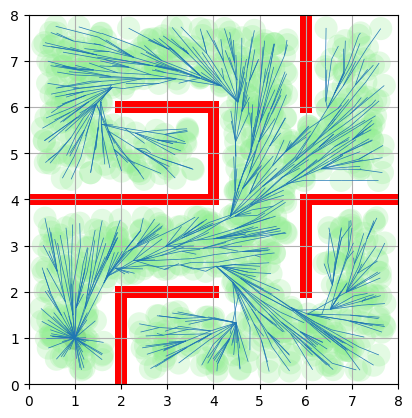

In [108]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

lc = mc.LineCollection(Edges, linewidths=0.5)
ax.add_collection(lc)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in Vertices:
  if v == rootVertex:
    #plt.scatter(v.x, v.y, color = 'blue')
    ax.add_patch(Circle((v.x, v.y), radius, facecolor='black', alpha = 0.25))
  else:
    #plt.scatter(v.x, v.y, color = 'black', s=1.5)
    ax.add_patch(Circle((v.x, v.y), radius, facecolor='lightgreen', alpha = 0.25))

plt.grid()
plt.show()

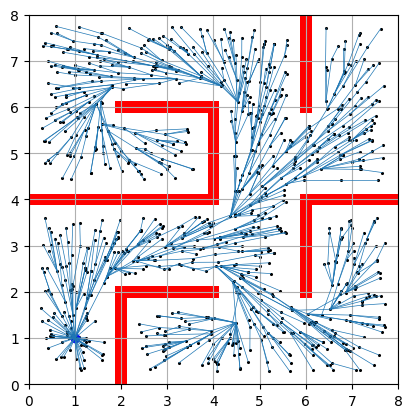

In [109]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

lc = mc.LineCollection(Edges, linewidths=0.5)
ax.add_collection(lc)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in Vertices:
  if v == rootVertex:
    plt.scatter(v.x, v.y, color = 'blue')
    #ax.add_patch(Circle((v.x, v.y), radius, facecolor='black', alpha = 0.25))
  else:
    plt.scatter(v.x, v.y, color = 'black', s=1.5)
    #ax.add_patch(Circle((v.x, v.y), radius, facecolor='yellow', alpha = 0.25))

plt.grid()
plt.show()

## Funcion de camino a Región Objetivo

In [128]:
def pathToGoal(V, goalx, goaly, r):
  pathVertices = []
  pathEdges = []

  if sampleFree(goalx, goaly, radius) == False:
    print("El objetivo especificado colisiona o no es valido")
    return pathVertices, pathEdges

  #Escogemos aleatoriamente un vertice del grafo dentro de la region objetivo
  nearVertices = Near(V, goalx, goaly, r)

  if len(nearVertices) == 0:
    print("No se encontraron muestras cerca del objetivo")
    return pathVertices, pathEdges

  goalVertex = random.choice(tuple(nearVertices))
  currentVertex = goalVertex

  while True:
    pathVertices.append(currentVertex)

    if currentVertex == rootVertex:
      break

    pathEdges.append(((currentVertex.parent.x, currentVertex.parent.y), (currentVertex.x, currentVertex.y)))

    currentVertex = currentVertex.parent

  return pathVertices, pathEdges

In [132]:
goal_x = 3
goal_y = 5
goal_r = 0.5
pathV, pathE = pathToGoal(Vertices, goal_x, goal_y, goal_r)

In [133]:
for v in pathV:
    print(v.x, " ", v.y)

3.047141517046978   4.7141140395353975
2.8192219916860357   4.815975929722079
2.321324734158434   5.109373609290596
1.7212031054098385   5.485827047035431
1.560231329284934   6.118591795404603
1.7951627790339155   6.482025168156092
2.48419107916056   6.6183498196088255
3.193540065331264   6.612053146207719
4.171141438917406   6.456458905706642
4.528978342588266   6.107241565972126
4.467580636738577   5.430027517140697
4.485755724461495   4.930357960147013
4.469118281136484   4.1826199177233505
4.367763005801003   3.633238045982281
3.790307587630257   3.277663107785119
3.135022933042492   2.9459313616063736
2.3514104260281203   2.662690249612324
1.689767525624633   2.3300733575908095
1.6299007016189766   2.193214111531884
1.2449721922293453   1.4358768461783085
1   1


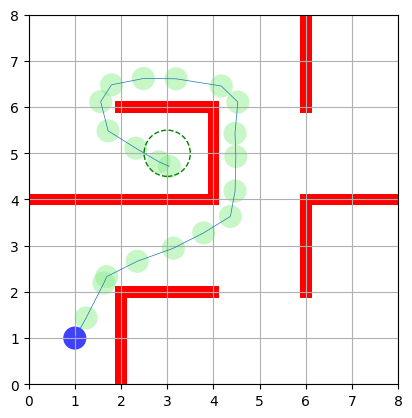

In [134]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

lc = mc.LineCollection(pathE, linewidths=0.5)
ax.add_collection(lc)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in pathV:
  if v == rootVertex:
    #plt.scatter(v.x, v.y, color = 'blue')
    ax.add_patch(Circle((v.x, v.y), radius, facecolor='blue', alpha = 0.75))
  else:
    #plt.scatter(v.x, v.y, color = 'black', s=1.5)
    ax.add_patch(Circle((v.x, v.y), radius, facecolor='lightgreen', alpha = 0.5))

ax.add_patch(Circle((goal_x, goal_y), goal_r, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()

# Muestras iniciales aleatorias por celda

## Generacion de muestras

In [37]:
class celda:
  infX = ''
  infY = ''
  supX = ''
  supY = ''

  def __init__(self, infx, supx, infy, supy):
    self.infX = infx
    self.infY = infy
    self.supX = supx
    self.supY = supy

In [38]:
#Declaramos las 16 celdas del laberinto
mazeCells = []

#(De abajo hacia arriba)#
#Primera fila
mazeCells.append(celda(0, 2, 0, 2))
mazeCells.append(celda(2, 4, 0, 2))
mazeCells.append(celda(4, 6, 0, 2))
mazeCells.append(celda(6, 8, 0, 2))

#Segunda fila
mazeCells.append(celda(0, 2, 2, 4))
mazeCells.append(celda(2, 4, 2, 4))
mazeCells.append(celda(4, 6, 2, 4))
mazeCells.append(celda(6, 8, 2, 4))

#Tercera fila
mazeCells.append(celda(0, 2, 4, 6))
mazeCells.append(celda(2, 4, 4, 6))
mazeCells.append(celda(4, 6, 4, 6))
mazeCells.append(celda(6, 8, 4, 6))

#Cuarta fila
mazeCells.append(celda(0, 2, 6, 8))
mazeCells.append(celda(2, 4, 6, 8))
mazeCells.append(celda(4, 6, 6, 8))
mazeCells.append(celda(6, 8, 6, 8))

In [70]:
initSamples = []

samplesPerCell = 10

for c in mazeCells:
    i = 0
    while i < 10:
        #Generamos punto aleatorio xrand
        xrand_x = np.random.uniform(c.infX, c.supX)
        xrand_y = np.random.uniform(c.infY, c.supY)

        #Verificamos que el punto aleatorio este libre de colisiones
        if sampleFree(xrand_x, xrand_y, radius):
            initSamples.append(np.array([xrand_x, xrand_y]))
            i+=1

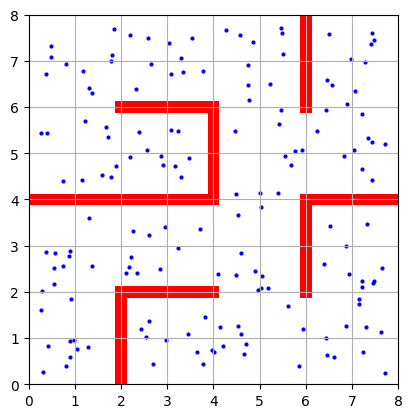

In [71]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for s in initSamples:
    plt.scatter(s[0], s[1], color = 'blue', s=4.0)

plt.grid()
plt.show()

## Construcción de muestras por archivo de texto

In [73]:
file = open("initialPoints.txt", "w")

for s in initSamples:
    file.write(str(s[0]))
    file.write(" ")
    file.write(str(s[1]))
    file.write("\n")

file.close()

### Arreglo de todos los puntos

In [75]:
initialPoints = []

with open("initialPoints.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        initialPoints.append(np.array([x, y]))

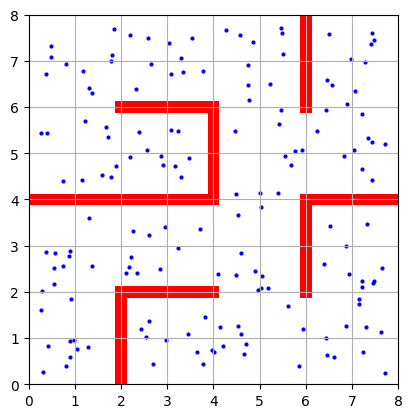

In [96]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for p in initialPoints:
    plt.scatter(p[0], p[1], color = 'blue', s=4.0)

plt.grid()
plt.show()

### Almacenamiento de puntos por celda

In [87]:
initialPointsCell = []

for i in range(16):
    pointsOfCell = []
    for j in range(10):
        pointsOfCell.append(initialPoints[10*i + j])
        
    initialPointsCell.append(pointsOfCell)
    i+=1

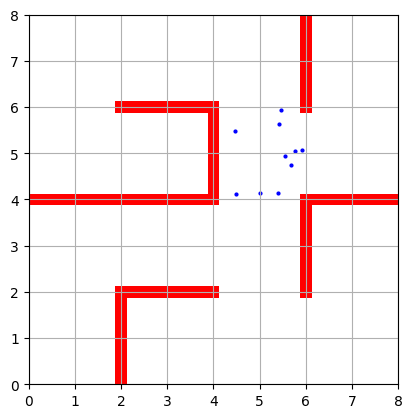

In [97]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


for p in initialPointsCell[10]:
    plt.scatter(p[0], p[1], color = 'blue', s=4.0)

plt.grid()
plt.show()

# Registro de trayectorias de prueba

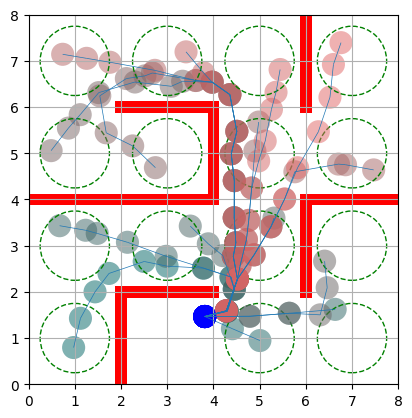

In [170]:
trayectorias = []
initCell = 1
rv = initialPointsCell[initCell][3]
rootVertex = vertex(rv[0], rv[1], None)
Vertices, Edges = RRT_star(1000, rootVertex)

file = open("trayectoriasPrueba.txt", "w")

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for i in range(16):
    if i != initCell:
        trayectoria = []
        goalx = (mazeCells[i].supX - mazeCells[i].infX)/2 + mazeCells[i].infX
        goaly = (mazeCells[i].supY - mazeCells[i].infY)/2 + mazeCells[i].infY
        goalr = 0.75

        pathV, pathE = pathToGoal(Vertices, goalx, goaly, goalr)
        lc = mc.LineCollection(pathE, linewidths=0.5)
        ax.add_collection(lc)

        for v in pathV:
            trayectoria.append([v.x, v.y])
            if v == rootVertex:
                #plt.scatter(v.x, v.y, color = 'blue')
                ax.add_patch(Circle((v.x, v.y), radius, facecolor='blue', alpha = 0.75))
            else:
                #plt.scatter(v.x, v.y, color = 'black', s=1.5)
                color_rgb = ((15*i)/255, (100)/255, (100)/255)
                ax.add_patch(Circle((v.x, v.y), radius, facecolor= color_rgb, alpha = 0.5))

        ax.add_patch(Circle((goalx, goaly), goalr, edgecolor='green', ls = '--', fill = False))
        
        trayectoria.reverse()
        trayectorias.append(trayectoria)

        for point in trayectoria:
            file.write(str(point[0]))
            file.write(" ")
            file.write(str(point[1]))
            file.write(" ")
        
        file.write("\n")

file.close()
plt.grid()
plt.show()
        

In [171]:
len(trayectorias)

15

In [172]:
trayectorias

[[[3.8135224574453748, 1.4668032964071702],
  [4.300372820851612, 1.5807187196439498],
  [4.452315812988212, 2.057072923089849],
  [4.38091766208412, 2.3215884933760873],
  [3.784104483376184, 2.514439640366458],
  [2.997008893813431, 2.5570602191774467],
  [2.5023202464271095, 2.657704864349289],
  [1.7400361142119876, 2.3993503384811556],
  [1.43811666337415, 2.000797148548145],
  [1.1224641663117394, 1.4282690441511185],
  [0.9747798131682422, 0.7951349387244164]],
 [[3.8135224574453748, 1.4668032964071702],
  [4.411738623847532, 1.2025711040558489],
  [5.006633990321505, 0.9467755685425201]],
 [[3.8135224574453748, 1.4668032964071702],
  [4.791561343885376, 1.4727520641544516],
  [5.643342215198911, 1.537384647350062],
  [6.6356530932447315, 1.62107643796483]],
 [[3.8135224574453748, 1.4668032964071702],
  [4.300372820851612, 1.5807187196439498],
  [4.452315812988212, 2.057072923089849],
  [4.38091766208412, 2.3215884933760873],
  [3.784104483376184, 2.514439640366458],
  [2.977591

In [173]:
print(trayectorias[0])

[[3.8135224574453748, 1.4668032964071702], [4.300372820851612, 1.5807187196439498], [4.452315812988212, 2.057072923089849], [4.38091766208412, 2.3215884933760873], [3.784104483376184, 2.514439640366458], [2.997008893813431, 2.5570602191774467], [2.5023202464271095, 2.657704864349289], [1.7400361142119876, 2.3993503384811556], [1.43811666337415, 2.000797148548145], [1.1224641663117394, 1.4282690441511185], [0.9747798131682422, 0.7951349387244164]]


# Registro de trayectorias

NOTA: *No ejecutar* la siguiente celda a menos que se desee sobreescribir las trayectorias (base de datos) actual

In [174]:
trayectorias = []
file = open("trayectorias.txt", "w")

for initCell in range(16):
    for initPoint in range(10):
        rv = initialPointsCell[initCell][initPoint]
        rootVertex = vertex(rv[0], rv[1], None)
        Vertices, Edges = RRT_star(1000, rootVertex)

        for i in range(16):
            if i != initCell:
                trayectoria = []
                goalx = (mazeCells[i].supX - mazeCells[i].infX)/2 + mazeCells[i].infX
                goaly = (mazeCells[i].supY - mazeCells[i].infY)/2 + mazeCells[i].infY
                goalr = 0.75

                pathV, pathE = pathToGoal(Vertices, goalx, goaly, goalr)

                for v in pathV:
                    trayectoria.append([v.x, v.y])
                
                trayectoria.reverse()
                trayectorias.append(trayectoria)

                for point in trayectoria:
                    file.write(str(point[0]))
                    file.write(" ")
                    file.write(str(point[1]))
                    file.write(" ")
        
                file.write("\n")
    
    print("Celda", initCell, "completada")

file.close()

Celda 0 completada
Celda 1 completada
Celda 2 completada
Celda 3 completada
Celda 4 completada
Celda 5 completada
Celda 6 completada
Celda 7 completada
Celda 8 completada
Celda 9 completada
Celda 10 completada
Celda 11 completada
Celda 12 completada
Celda 13 completada
Celda 14 completada
Celda 15 completada


In [175]:
len(trayectorias)

2400

# Predicción de trayectoria con Redes Neuronales

## Dataframe para entrenamiento

In [15]:
# Lee el archivo de texto
with open('trayectorias.txt', 'r') as file:
    lines = file.readlines()

data = []
# Procesa cada línea del archivo
for line in lines:
    # Separa los números en cada línea
    points = line.split()
    # Construimos las tuplas (q_t, q_goal) y q_{t+1}
    for i in range(0, len(points)-2, 2):
        q_t_and_q_goal = [float(points[i]), float(points[i+1]), float(points[-2]), float(points[-1])]
        q_next = [float(points[i+2]), float(points[i+3])]
        data.append([q_t_and_q_goal, q_next])

file.close()


In [16]:
# Crea el dataframe
train_df = pd.DataFrame(data, columns=['(q_t, q_goal)', 'q_{t+1}'])
train_df.head()

,"(q_t, q_goal)",q_{t+1}
0,"[1.0523528875907853, 0.7584937909327754, 2.912...","[1.4495858257048675, 1.4999029768033791]"
1,"[1.4495858257048675, 1.4999029768033791, 2.912...","[1.5947193108633853, 2.318843593175416]"
2,"[1.5947193108633853, 2.318843593175416, 2.9120...","[1.885385383680359, 2.401730081913539]"
3,"[1.885385383680359, 2.401730081913539, 2.91208...","[2.462165918956636, 2.532442989817817]"
4,"[2.462165918956636, 2.532442989817817, 2.91208...","[3.223269828423378, 2.5937623692258263]"


In [17]:
X = train_df["(q_t, q_goal)"].tolist()
Y = train_df["q_{t+1}"].tolist()

X = np.asarray(X)
Y = np.asarray(Y)

In [23]:
X

array([[1.05235289, 0.75849379, 2.91208808, 1.08849524],
       [1.44958583, 1.49990298, 2.91208808, 1.08849524],
       [1.59471931, 2.31884359, 2.91208808, 1.08849524],
       ...,
       [5.88684148, 5.54361422, 4.84375308, 7.43968389],
       [5.33151973, 5.99894547, 4.84375308, 7.43968389],
       [5.07378142, 6.91221386, 4.84375308, 7.43968389]])

In [24]:
Y

array([[1.44958583, 1.49990298],
       [1.59471931, 2.31884359],
       [1.88538538, 2.40173008],
       ...,
       [5.33151973, 5.99894547],
       [5.07378142, 6.91221386],
       [4.84375308, 7.43968389]])

## Puntos de inicio-fin aleatorios para prueba

In [20]:
# Leer los datos del archivo de texto
testStartEnd = np.loadtxt('randomStartEnd.txt')
print(len(testStartEnd))
# Imprimir los arreglos leídos
print("Arreglos leídos del archivo:")
for testarray in testStartEnd:
    print(testarray)

100
Arreglos leídos del archivo:
[0.52487734 0.74404224 5.80209241 4.4399534 ]
[7.07208366 1.42891251 0.67212556 0.59518626]
[5.86988382 4.58690591 4.33915045 7.12155994]
[1.11308728 0.82414198 3.356034   2.62791461]
[0.89811852 2.82971072 3.22546021 1.44259316]
[0.41975564 3.09936053 6.56694507 1.993346  ]
[0.41480476 7.31585381 2.54109136 4.40642506]
[5.41210812 5.10176324 4.37874955 4.59320382]
[0.41937678 2.63836201 2.72223078 4.93395264]
[0.77897214 0.83696132 4.2982497  6.81464969]
[6.30807009 4.71106308 4.25711603 0.76985741]
[6.78477974 1.74544338 2.2065893  6.9043654 ]
[0.40625173 2.2292443  7.09718204 5.20276405]
[4.85527483 3.83081403 0.57710047 0.48539144]
[5.04402371 1.20168348 6.76556132 7.58802184]
[7.23520134 5.75913352 6.94181338 6.39018322]
[4.41971426 7.25411222 6.66349378 4.85951616]
[1.75621813 4.89082966 0.549699   6.56199793]
[0.40770758 7.68203098 7.57224701 7.14575921]
[2.96974334 7.5866397  2.62048311 0.78488347]
[2.5243499  7.47075618 6.88347515 5.07880398]
[

## Predicción con SKLEARN

In [38]:
clf = MLPRegressor(hidden_layer_sizes=(128, 64, 32), solver="lbfgs", max_iter=4000, alpha = 0)
clf.fit(X,Y)

c:\Users\ramon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0, hidden_layer_sizes=(128, 64, 32), max_iter=4000,
             solver='lbfgs')

### Predicción de prueba

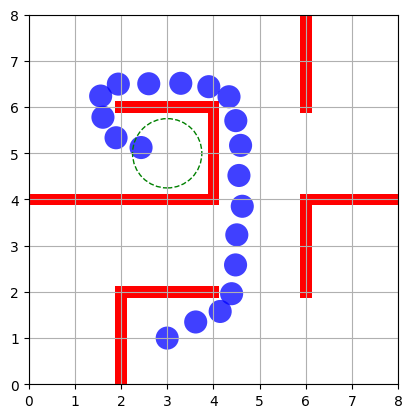

In [39]:
verticesPath = []
inicio = [3, 1]
goal = [3, 5]

#inicio = [1, 1]
#goal = [7, 3]

#inicio = [3, 5]
#goal = [7, 3]

qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75:
    qnext = clf.predict(qt)
    qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
    verticesPath.append([qnext[0][0],qnext[0][1]])

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), radius, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()

### Pruebas

In [41]:
successfulPaths = 0
times = []
costs = []
timesSuccessful = []
costsSuccessful = []


for testarray in testStartEnd:
    isSuccessful = True
    totalCost = 0

    start = time.time()

    verticesPath = []
    inicio = [testarray[0], testarray[1]]
    goal = [testarray[2], testarray[3]]

    qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
    verticesPath.append([qt[0][0],qt[0][1]])

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75:
        qnext = clf.predict(qt)

        totalCost += edgeCost(qt[0][0], qt[0][1], qnext[0][0], qnext[0][1])
        if collisionFree(qt[0][0], qt[0][1], qnext[0][0], qnext[0][1], radius) == False:
            isSuccessful = False

        qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
        verticesPath.append([qnext[0][0],qnext[0][1]])
    
    end = time.time()

    totalTime = end - start

    times.append(totalTime)
    costs.append(totalCost)

    if isSuccessful == True:
        timesSuccessful.append(totalTime)
        costsSuccessful.append(totalCost)
        successfulPaths += 1
        """
        fig, ax = plt.subplots()
        ax.set_xlim(liminf_X, limsup_X)
        ax.set_ylim(liminf_Y, limsup_Y)
        ax.set_aspect('equal')

        for i in range(len(obstacles)):
            ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
                facecolor = 'red',
                fill=True))

        for v in verticesPath:
            ax.add_patch(Circle((v[0], v[1]), radius, facecolor='blue', alpha = 0.75))

        ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))

        plt.grid()
        plt.show()
        """
    
times = np.array(times)
costs = np.array(costs)
timesSuccessful = np.array(timesSuccessful)
costsSuccessful = np.array(costsSuccessful)

print("---Prediccion con SKLEARN---")
print("Trayectorias exitosas:", successfulPaths)
print()
print("Promedio de tiempo:", np.mean(times))
print("Promedio de tiempo para trayectorias exitosas:", np.mean(timesSuccessful))
print("Desviacion estandar de tiempo:", np.std(times))
print("Desviacion estandar de tiempo para trayectorias exitosas:", np.std(timesSuccessful))
print()
print("Promedio de costo:", np.mean(costs))
print("Promedio de costo para trayectorias exitosas:", np.mean(costsSuccessful))
print("Desviacion estandar de costo:", np.std(costs))
print("Desviacion estandar de costo para trayectorias exitosas:", np.std(costsSuccessful))
    

---Prediccion con SKLEARN---
Trayectorias exitosas: 42

Promedio de tiempo: 0.004764442443847656
Promedio de tiempo para trayectorias exitosas: 0.003913533119928269
Desviacion estandar de tiempo: 0.0025753225349532246
Desviacion estandar de tiempo para trayectorias exitosas: 0.0024481437728638474

Promedio de costo: 5.6127996250381
Promedio de costo para trayectorias exitosas: 4.1226528933874045
Desviacion estandar de costo: 2.8724511363503122
Desviacion estandar de costo para trayectorias exitosas: 2.5446224936611466


## Predicción con TensorFlow

In [23]:
mlp = models.Sequential([
  layers.Dense(128, activation=PReLU()),
  layers.Dense(64),
	layers.Activation(activation=PReLU()),
  layers.Dense(32),
	layers.Activation(activation=PReLU()),
  layers.Dense(2),
])

In [ ]:
model_name = 'mlp'
version = 'v1'

models_path = 'C:/Users/ramon/Documents/Universidad/ProyectoRobotica/Modelos'
save_file_path = models_path+'trained_model_'+model_name +'_'+version+'_'+str(4000)+'_epochs.h5'

# Save the best model only wrt validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp.compile(loss=tf.keras.losses.MeanSquaredError(),
			optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Training
history = mlp.fit(x = X,
				    y = Y,
					batch_size = 128,
					epochs = 4000,
                    validation_split=0.05,
					verbose = 1,
                    callbacks=[model_checkpoint_callback]
                    )

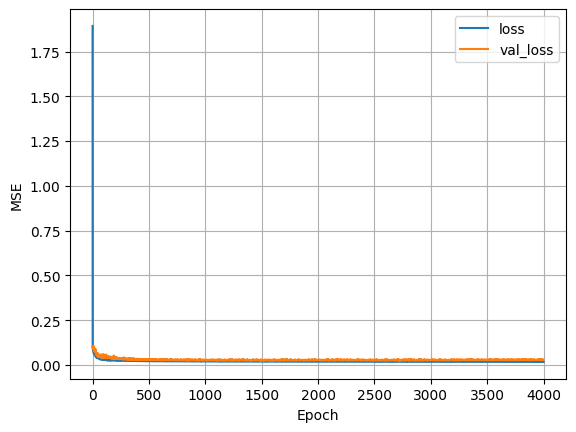

In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)


plot_loss(history)

### Importar modelo guardado

In [25]:
model_path = 'C:/Users/ramon/Documents/Universidad/ProyectoRobotica/Modelos/trained_model_mlp_v1_4000_epochs.h5'
mlp = keras.models.load_model(model_path)

### Predicción de prueba

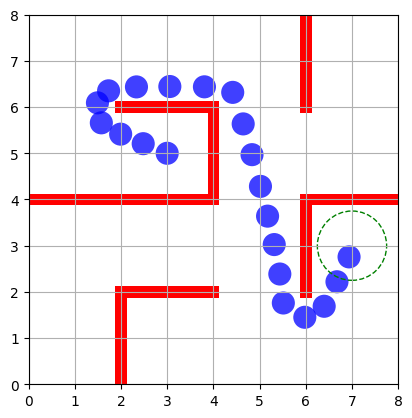

In [26]:
verticesPath = []
#inicio = [3, 5]
#goal = [7, 7]

#inicio = [3, 1]
#goal = [3, 5]

#inicio = [1, 1]
#goal = [7, 3]

inicio = [3, 5]
goal = [7, 3]

qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75:
    qnext = mlp.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), radius, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()

### Pruebas

In [29]:
successfulPaths = 0
times = []
costs = []
timesSuccessful = []
costsSuccessful = []


for testarray in testStartEnd:
    isSuccessful = True
    totalCost = 0

    start = time.time()

    verticesPath = []
    inicio = [testarray[0], testarray[1]]
    goal = [testarray[2], testarray[3]]

    qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
    verticesPath.append([qt[0][0],qt[0][1]])

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75:
        qnext = mlp.predict(qt, verbose=0)

        totalCost += edgeCost(qt[0][0], qt[0][1], qnext[0][0], qnext[0][1])
        if collisionFree(qt[0][0], qt[0][1], qnext[0][0], qnext[0][1], radius) == False:
            isSuccessful = False

        qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
        qt = np.asarray(qt)
        verticesPath.append([qnext[0][0],qnext[0][1]])
    
    end = time.time()

    totalTime = end - start

    times.append(totalTime)
    costs.append(totalCost)

    if isSuccessful == True:
        timesSuccessful.append(totalTime)
        costsSuccessful.append(totalCost)
        successfulPaths += 1

    """   
    fig, ax = plt.subplots()
    ax.set_xlim(liminf_X, limsup_X)
    ax.set_ylim(liminf_Y, limsup_Y)
    ax.set_aspect('equal')

    for i in range(len(obstacles)):
        ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
            facecolor = 'red',
            fill=True))

    for v in verticesPath:
        ax.add_patch(Circle((v[0], v[1]), radius, facecolor='blue', alpha = 0.75))

    ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))

    plt.grid()
    plt.show()
    """
    
times = np.array(times)
costs = np.array(costs)
timesSuccessful = np.array(timesSuccessful)
costsSuccessful = np.array(costsSuccessful)

print("---Prediccion con TENSORFLOW---")
print("Trayectorias exitosas:", successfulPaths)
print()
print("Promedio de tiempo:", np.mean(times))
print("Promedio de tiempo para trayectorias exitosas:", np.mean(timesSuccessful))
print("Desviacion estandar de tiempo:", np.std(times))
print("Desviacion estandar de tiempo para trayectorias exitosas:", np.std(timesSuccessful))
print()
print("Promedio de costo:", np.mean(costs))
print("Promedio de costo para trayectorias exitosas:", np.mean(costsSuccessful))
print("Desviacion estandar de costo:", np.std(costs))
print("Desviacion estandar de costo para trayectorias exitosas:", np.std(costsSuccessful))
    

---Prediccion con TENSORFLOW---
Trayectorias exitosas: 59

Promedio de tiempo: 0.3478656244277954
Promedio de tiempo para trayectorias exitosas: 0.287546703370951
Desviacion estandar de tiempo: 0.166166177356042
Desviacion estandar de tiempo para trayectorias exitosas: 0.16752492515287534

Promedio de costo: 5.797702307114808
Promedio de costo para trayectorias exitosas: 4.809411815147328
Desviacion estandar de costo: 2.8346233961891305
Desviacion estandar de costo para trayectorias exitosas: 2.7969550020656673


## Predicción con Tensorflow (con Dropout)

In [30]:
mlp2 = models.Sequential([
  layers.Dense(128, activation=PReLU()),
  layers.Dense(64),
	layers.Activation(activation=PReLU()),
	layers.Dropout(0.25),
  layers.Dense(32),
	layers.Dropout(0.25),
	layers.Activation(activation=PReLU()),
  layers.Dense(2),
])

In [31]:
model_name = 'mlp2'
version = 'v1'

models_path = 'C:/Users/ramon/Documents/Universidad/ProyectoRobotica/Modelos'
save_file_path = models_path+'trained_model_'+model_name +'_'+version+'_'+str(4000)+'_epochs.h5'

# Save the best model only wrt validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp2.compile(loss=tf.keras.losses.MeanSquaredError(),
			optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Training
history2 = mlp2.fit(x = X,
				    y = Y,
					batch_size = 128,
					epochs = 4000,
                    validation_split=0.05,
					verbose = 1,
                    callbacks=[model_checkpoint_callback]
                    )

Epoch 1/4000
181/181 [==============================] - 1s 2ms/step - loss: 1.8801 - val_loss: 0.1233
Epoch 2/4000
181/181 [==============================] - 0s 2ms/step - loss: 0.7805 - val_loss: 0.1128
Epoch 3/4000
181/181 [==============================] - 0s 2ms/step - loss: 0.6422 - val_loss: 0.1076
Epoch 4/4000
181/181 [==============================] - 0s 2ms/step - loss: 0.5860 - val_loss: 0.0894
Epoch 5/4000
181/181 [==============================] - 0s 2ms/step - loss: 0.5597 - val_loss: 0.0989
Epoch 6/4000
181/181 [==============================] - 0s 2ms/step - loss: 0.5325 - val_loss: 0.0929
Epoch 7/4000
181/181 [==============================] - 0s 2ms/step - loss: 0.5053 - val_loss: 0.1458
Epoch 8/4000
181/181 [==============================] - 0s 2ms/step - loss: 0.5008 - val_loss: 0.1054
Epoch 9/4000
181/181 [==============================] - 0s 2ms/step - loss: 0.4835 - val_loss: 0.1096
Epoch 10/4000
181/181 [==============================] - 0s 2ms/step - loss: 0.465

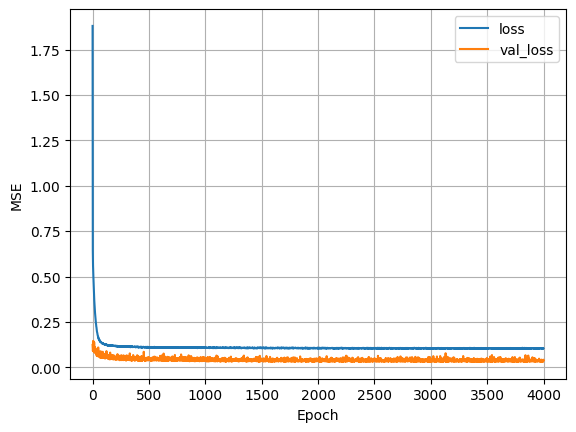

In [32]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)


plot_loss(history2)

### Importar modelo guardado

In [35]:
model_path = 'C:/Users/ramon/Documents/Universidad/ProyectoRobotica/Modelos/trained_model_mlp2_v1_4000_epochs.h5'
mlp2 = keras.models.load_model(model_path)

### Predicción de prueba

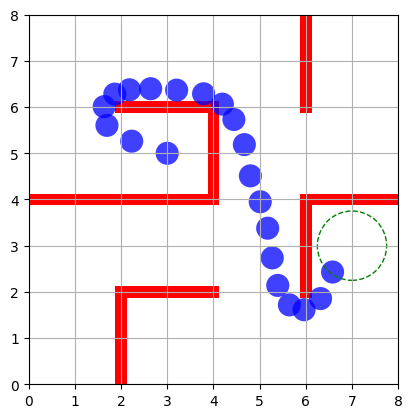

In [36]:
verticesPath = []
#inicio = [3, 5]
#goal = [7, 7]

#inicio = [3, 1]
#goal = [3, 5]

#inicio = [1, 1]
#goal = [7, 3]

inicio = [3, 5]
goal = [7, 3]

qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75:
    qnext = mlp2.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), radius, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()

### Pruebas

In [37]:
successfulPaths = 0
times = []
costs = []
timesSuccessful = []
costsSuccessful = []


for testarray in testStartEnd:
    isSuccessful = True
    totalCost = 0

    start = time.time()

    verticesPath = []
    inicio = [testarray[0], testarray[1]]
    goal = [testarray[2], testarray[3]]

    qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
    verticesPath.append([qt[0][0],qt[0][1]])

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75:
        qnext = mlp2.predict(qt, verbose=0)

        totalCost += edgeCost(qt[0][0], qt[0][1], qnext[0][0], qnext[0][1])
        if collisionFree(qt[0][0], qt[0][1], qnext[0][0], qnext[0][1], radius) == False:
            isSuccessful = False

        qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
        qt = np.asarray(qt)
        verticesPath.append([qnext[0][0],qnext[0][1]])
    
    end = time.time()

    totalTime = end - start

    times.append(totalTime)
    costs.append(totalCost)

    if isSuccessful == True:
        timesSuccessful.append(totalTime)
        costsSuccessful.append(totalCost)
        successfulPaths += 1

    """   
    fig, ax = plt.subplots()
    ax.set_xlim(liminf_X, limsup_X)
    ax.set_ylim(liminf_Y, limsup_Y)
    ax.set_aspect('equal')

    for i in range(len(obstacles)):
        ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
            facecolor = 'red',
            fill=True))

    for v in verticesPath:
        ax.add_patch(Circle((v[0], v[1]), radius, facecolor='blue', alpha = 0.75))

    ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))

    plt.grid()
    plt.show()
    """
    
times = np.array(times)
costs = np.array(costs)
timesSuccessful = np.array(timesSuccessful)
costsSuccessful = np.array(costsSuccessful)

print("---Prediccion con TENSORFLOW (DROPOUT)---")
print("Trayectorias exitosas:", successfulPaths)
print()
print("Promedio de tiempo:", np.mean(times))
print("Promedio de tiempo para trayectorias exitosas:", np.mean(timesSuccessful))
print("Desviacion estandar de tiempo:", np.std(times))
print("Desviacion estandar de tiempo para trayectorias exitosas:", np.std(timesSuccessful))
print()
print("Promedio de costo:", np.mean(costs))
print("Promedio de costo para trayectorias exitosas:", np.mean(costsSuccessful))
print("Desviacion estandar de costo:", np.std(costs))
print("Desviacion estandar de costo para trayectorias exitosas:", np.std(costsSuccessful))
    

---Prediccion con TENSORFLOW (DROPOUT)---
Trayectorias exitosas: 37

Promedio de tiempo: 0.381184983253479
Promedio de tiempo para trayectorias exitosas: 0.23231169984147354
Desviacion estandar de tiempo: 0.21297834178086247
Desviacion estandar de tiempo para trayectorias exitosas: 0.13864136028108068

Promedio de costo: 5.540206450760024
Promedio de costo para trayectorias exitosas: 3.47860038676304
Desviacion estandar de costo: 2.898166026596196
Desviacion estandar de costo para trayectorias exitosas: 2.153389958964665
